<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/denoise_additive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
!git pull origin master
!pip install gputil
!pip install psutil
!pip install humanize
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

/content
Cloning into 'deepLearning'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 333 (delta 45), reused 35 (delta 14), pack-reused 245
Receiving objects: 100% (333/333), 150.54 MiB | 19.45 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Checking out files: 100% (103/103), done.
/content/deepLearning
From https://github.com/AlexMontgomerie/deepLearning
 * branch            master     -> FETCH_HEAD
Already up to date.
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
('RAM Free: 12.9 GB', ' | Proc size: 154.0 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [3]:
from common import *
!./setup.sh

Using TensorFlow backend.


--2019-03-12 00:56:40--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 185.235.236.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-12 00:56:40--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-12 00:56:40--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.bo

In [4]:
from denoise_network import *
from get_data import get_data

EPOCHS = 50

seqs_train, seqs_test = get_data()

# get traning data

denoise_generator     = DenoiseHPatches(seqs_train, batch_size=500)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=500)

100%|██████████| 40/40 [00:43<00:00,  1.03it/s]


In [0]:

import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate, Subtract
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt

def get_denoise_model_additive(shape):

  inputs  = Input(shape)
  depth1  = 16
  conv1_1 = Conv2D(depth1, 1, padding = 'same', kernel_initializer = 'he_normal', name='denoise_in')(inputs)
  
  # convolution layers
  conv1_2  = Conv2D(depth1, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_2' )(conv1_1)
  conv1_3  = Conv2D(depth1, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_3' )(conv1_1)
  conv1_5  = Conv2D(depth1, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_5' )(conv1_1)
  conv1_7  = Conv2D(depth1, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_7' )(conv1_1)
  conv1_9  = Conv2D(depth1, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_9' )(conv1_1)
  conv1_11 = Conv2D(depth1, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_11')(conv1_1)
  
  # network
  net1 = Subtract()([conv1_1, conv1_2])
  net1 = BatchNormalization()(net1)
  net1 = Subtract()([conv1_1, conv1_3])
  net1 = BatchNormalization()(net1)
  net1 = Subtract()([conv1_1, conv1_5])
  net1 = BatchNormalization()(net1)
  net1 = Subtract()([conv1_1, conv1_7])
  net1 = BatchNormalization()(net1)
  net1 = Subtract()([conv1_1, conv1_9])
  net1 = BatchNormalization()(net1)
  net1 = Subtract()([conv1_1, conv1_11])
  net1 = BatchNormalization()(net1)  
  
  # convolution layers
  depth2 = 16
  #conv2_1  = Conv2D(depth2, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
  conv2_2  = Conv2D(depth2, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_2' )(net1)
  conv2_3  = Conv2D(depth2, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_3' )(net1)
  conv2_5  = Conv2D(depth2, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_5' )(net1)
  conv2_7  = Conv2D(depth2, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_7' )(net1)
  conv2_9  = Conv2D(depth2, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_9' )(net1)
  conv2_11 = Conv2D(depth2, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_11')(net1)
  
  # network
  net2 = Subtract()([net1, conv2_2])
  net2 = BatchNormalization()(net2)
  net2 = Subtract()([net1, conv2_3])
  net2 = BatchNormalization()(net2)
  net2 = Subtract()([net1, conv2_5])
  net2 = BatchNormalization()(net2)
  net2 = Subtract()([net1, conv2_7])
  net2 = BatchNormalization()(net2)
  net2 = Subtract()([net1, conv2_9])
  net2 = BatchNormalization()(net2)
  net2 = Subtract()([net1, conv2_11])
  net2 = BatchNormalization()(net2)  
  
  # convolution layers
  depth3 = 16
  #conv3_1  = Conv2D(depth3, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
  conv3_2  = Conv2D(depth3, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_2' )(net2)
  conv3_3  = Conv2D(depth3, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_3' )(net2)
  conv3_5  = Conv2D(depth3, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_5' )(net2)
  conv3_7  = Conv2D(depth3, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_7' )(net2)
  conv3_9  = Conv2D(depth3, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_9' )(net2)
  conv3_11 = Conv2D(depth3, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_11')(net2)
  
  # network
  net3 = Subtract()([net2, conv3_2])
  net3 = BatchNormalization()(net3)
  net3 = Subtract()([net2, conv3_3])
  net3 = BatchNormalization()(net3)
  net3 = Subtract()([net2, conv3_5])
  net3 = BatchNormalization()(net3)
  net3 = Subtract()([net2, conv3_7])
  net3 = BatchNormalization()(net3)
  net3 = Subtract()([net2, conv3_9])
  net3 = BatchNormalization()(net3)
  net3 = Subtract()([net2, conv3_11])
  net3 = BatchNormalization()(net3)  
  
  net = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_out' )(net3)
  
  return Model(inputs = inputs, outputs = net)

# optimiser
opt  = opt = keras.optimizers.nadam()

# train network
def ssim_loss(clean,noisy):
  return 1 - tf.image.ssim(clean, noisy, max_val=1.0)

def snr_loss(clean,noisy):
  tmp = tf.image.psnr(clean, noisy, max_val=1.0)
  print(tmp)
  return - tmp

In [14]:
# get model
shape = (32, 32, 1)
denoise_model = get_denoise_model_additive(shape)

# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/denoise_model_mae.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

denoise_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])
denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=EPOCHS, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)

Epoch 1/50
3117/3117 [==============================] - 522s 168ms/step - loss: 22.0756 - acc: 0.0429 - val_loss: 5.9900 - val_acc: 0.0655

Epoch 00001: val_loss improved from inf to 5.98998, saving model to data/denoise_model_mae.weights.01-5.99.hdf5
Epoch 2/50
3117/3117 [==============================] - 520s 167ms/step - loss: 6.4310 - acc: 0.0582 - val_loss: 5.9043 - val_acc: 0.0659

Epoch 00002: val_loss improved from 5.98998 to 5.90428, saving model to data/denoise_model_mae.weights.02-5.90.hdf5
Epoch 3/50
3117/3117 [==============================] - 520s 167ms/step - loss: 6.2954 - acc: 0.0596 - val_loss: 5.9019 - val_acc: 0.0659

Epoch 00003: val_loss improved from 5.90428 to 5.90191, saving model to data/denoise_model_mae.weights.03-5.90.hdf5
Epoch 4/50
3117/3117 [==============================] - 520s 167ms/step - loss: 6.1477 - acc: 0.0613 - val_loss: 5.6397 - val_acc: 0.0696

Epoch 00004: val_loss improved from 5.90191 to 5.63970, saving model to data/denoise_model_mae.weig

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


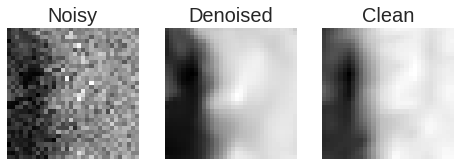

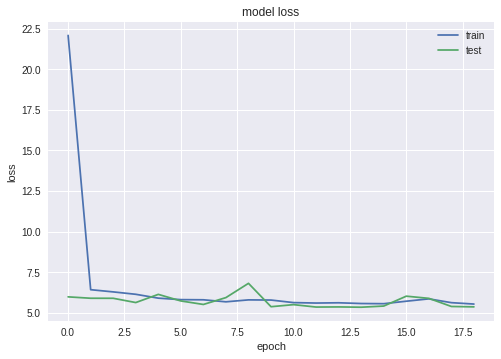

In [16]:
plot_denoise(denoise_model)
plt.plot(denoise_history.history['loss'])
plt.plot(denoise_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()